In [1]:
%matplotlib inline

# this allows you to edit pilotnet.py without restarting the notebook - use with caution

# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 1
%aimport pilotnet

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, add
from tensorflow.keras import regularizers

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import datetime
import glob
import time
from sklearn.model_selection import train_test_split

# some parameters and image preprocessing functions for pilotnet:
import pilotnet as p

To copy data from the car, **replace `RACECAR_IP`** with the address to your car and copy the folder collected using `record_RACECAR.py` to the environment you are using for training:

```
scp -r racecar@RACECAR_IP:~/imitation_learning_lab/run_DATE ./data_and_models/collects/
```

In [3]:
# CSVs from record_RACECAR.py

driving_data = [ "../data_and_models/collects/run_04_20_06_14/run_04_20_06_14.csv" 
                # ,"../data_and_models/collects/run_04_12_18_47/run_04_12_18_47.csv"
                # "../data_and_models/collects/run_04_05_16_16/run_04_05_16_16.csv"
               ]

for f in driving_data:
    parent_dir = os.path.dirname(f) + os.path.sep
    print(len(os.listdir(parent_dir)), " files found")

23323  files found


This notebook will train an implementation of Nvidia's PilotNet using TensorFlow/Keras. As an exercise you should modify some or all of the following and compare against the baseline implementation here.

* Drop out probability
* Number of epochs  
* Samples per epoch  
* Batch size         
* Learning rate
* Model layers, outputs: e.g., add regularization, or speed prediction
* Image size (cropped or scaled)
* Image augmentation


Some comparison metrics:

* Can you drive faster than the baseline?
* Do you require less data to train? More?
* Model generalization:
    * Can your model be used on a different car? 
    * Can you slightly change the angle of the front camera at inference time?
    * Does the presence of people or lighting variations affect your model's performance?

In [4]:
imgs   = []
ngls   = []
speeds = []
lines  = 0

for f in driving_data:
    parent_dir = os.path.dirname(f) + os.path.sep
    with open(f) as fh:
        for line in fh:
            lines = lines + 1
            l = line.split(',')

            speed = l[2]
            speed = float(speed)

            # filter out data when the car is stopped
            #if np.isclose(speed, 0.):
            if speed < 0.5:
                continue

            speeds.append(speed)

            img = l[0]
            imgs.append(parent_dir + img)

            ngl = l[1]
            ngl = float(ngl)
            ngls.append(ngl)
print("total data", lines)
print("filtered data", len(imgs), len(ngls), len(speeds))

total data 23322
filtered data 21504 21504 21504


These histograms of steering angles and speeds can be useful for sanity checking and considering what you should set `OFFSET_STEERING_ANGLE` to in `pilotnet.py` (which defines the magnitude of the pseudo-"corrective" steering angles applied to images taken from the left/right cameras during training below)

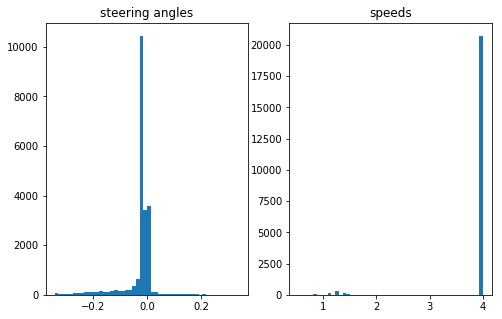

In [5]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(ngls, bins=50);
ax[1].hist(speeds, bins=50);
ax[0].set_title("steering angles")
ax[1].set_title("speeds")
fig.set_size_inches(8,5);

In case you accidentally goofed up your camera device ID order when recording data, you can work around it by changing the order of the elements in the returned tuple here:

In [20]:
def split_lcr(image, width=320, height=240):
    left   = image[0:height, 0:width, :]
    center = image[0:height, width:(width*2), :]
    right  = image[0:height, (width*2):(width*3), :]
    
    return (left, center, right)

angle: -0.012


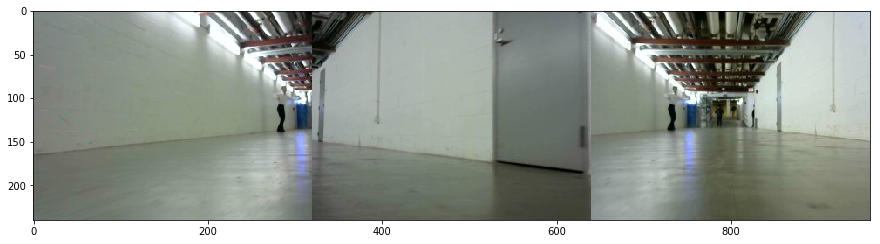

In [21]:
random_id = np.random.randint(0, len(imgs)-1)

img = cv.imread(imgs[random_id], cv.IMREAD_COLOR)

print("angle: {:02.3f}".format(ngls[random_id]))
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(rgb)
fig.set_size_inches(15,5);

magnitude of steering angle offset: 0.1
size: (120, 280)


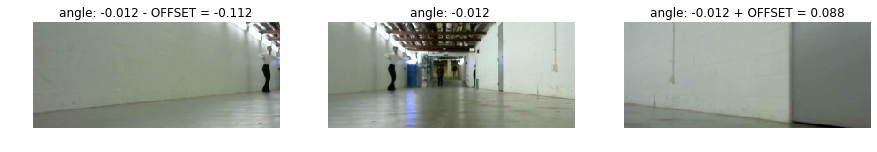

In [22]:
fig, ax = plt.subplots(ncols=3)
l,c,r = split_lcr(rgb)

print("magnitude of steering angle offset: {}".format(p.OFFSET_STEERING_ANGLE))

l = p.preprocess(l)
c = p.preprocess(c)
r = p.preprocess(r)

print("size: {}".format(c.shape[:2]))

ax[0].imshow(l)
ax[1].imshow(c)
ax[2].imshow(r)

ngl = ngls[random_id]
ax[0].set_title("angle: {:02.3f} - OFFSET = {:02.3f}".format(ngl, ngl - p.OFFSET_STEERING_ANGLE))
ax[1].set_title("angle: {:02.3f} ".format(ngl))
ax[2].set_title("angle: {:02.3f} + OFFSET = {:02.3f}".format(ngl, ngl + p.OFFSET_STEERING_ANGLE))

for a in ax.flatten():
    a.axis('off')
fig.set_size_inches(15,5);

## Image Augmentation

Here are some examples of image augmentation. One simply increases the brightness ("value" channel in the HSV colorspace), another perturbs the gamma value of the input image, and the third adds a random shadow. Try other augmentation techniques to increase the model's robustness. 

Note that it can take some experimentation to determine which augmentations help - some augmentation strategies might hurt performance. For instance, would it make sense to flip images horizontally or vertically?

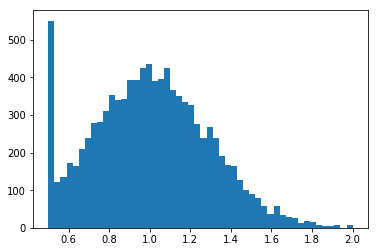

In [23]:
def increase_brightness(img):
    # perceptually a bit more uniform than perturb_gamma
    value = np.random.randint(20,60)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return img

def make_random_gamma():
    random_gamma = np.random.normal(1, 0.3)
    random_gamma = np.clip(random_gamma, 0.5, 2)
    return random_gamma

def perturb_gamma(img): # https://stackoverflow.com/a/51174313
    gamma = make_random_gamma()
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv.LUT(img, table.astype(np.uint8))

def random_shadow(image):
    # source: https://github.com/naokishibuya/car-behavioral-cloning/
    #         blob/edf20618fddb975c953f06b0549cba8716e27999/utils.py#L84
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.7, high=0.9)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv.cvtColor(image, cv.COLOR_BGR2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv.cvtColor(hls, cv.COLOR_HLS2BGR)

# visualize the distribution of random gamma perturbations
rg = [make_random_gamma() for i in range(10000)]
plt.hist(rg, bins=50);

random gamma


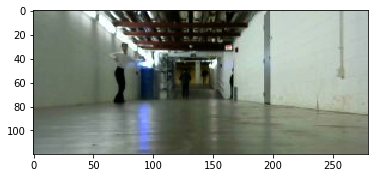

In [29]:
# visualize the effects of augmentation
q = np.copy(c)
qbgr = cv.cvtColor(q, cv.COLOR_RGB2BGR)
if np.random.random() < 0.5:
    print("increasing brighness")
    qbgr = increase_brightness(qbgr)
else:
    print("random gamma")
    qbgr = perturb_gamma(qbgr)
q = cv.cvtColor(qbgr, cv.COLOR_BGR2RGB)
plt.imshow(q);

Split the data into training and validation subsets. Optionally randomize order and/or use a fixed seed:

In [30]:
VAL_SIZE_FRACTION = 0.15
SEED = 56709 #awoo

X_train, X_valid, y_train, y_valid = train_test_split(
    imgs, 
    ngls, 
    test_size=VAL_SIZE_FRACTION, 
    shuffle=False
)
#,random_state=SEED)

print(len(X_train), len(X_valid))

18278 3226


In [31]:
def build_model(dropout_rate=0.5):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=p.INPUT_SHAPE)) #normalize the data
    model.add(Conv2D(24, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary() # prints out the model description
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 120, 280, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 58, 138, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 67, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 32, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 30, 64)        27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 28, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 8, 28, 64)         0         
__________

In [32]:
MODEL_NAME = "stata_{}_".format(datetime.datetime.now().strftime("%m_%d_%H_%M")) 

model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

checkpoint = ModelCheckpoint(MODEL_NAME + '{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=False,
                             mode='auto')

In [33]:
def augment(img):
    ################################
    ## TODO
    ## add more augmentations here
    #################################

    augment = np.random.rand()
    # augment half the time
    if augment < 0.5:
        do_gamma = np.random.rand()
        if do_gamma < 0.5:
            img = perturb_gamma(img)
        else:
            img = increase_brightness(img)
    return img

In [34]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, p.IMAGE_HEIGHT, p.IMAGE_WIDTH, p.IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            
            lcr_image = cv.imread(image_paths[index])
            l,c,r = split_lcr(lcr_image)
            
            l = p.preprocess(l)
            c = p.preprocess(c)
            r = p.preprocess(r)
            
            groundtruth_steering_angle = steering_angles[index]
            
            if is_training:
                dice = np.random.rand()
                # choose left
                if dice < 0.2:
                    images[i] = augment(l)
                    # correct by turning right (negative angle)
                    steers[i] = groundtruth_steering_angle - p.OFFSET_STEERING_ANGLE
                # choose right
                elif dice > 0.8:
                    images[i] = augment(r)
                    # correct by turning left (positive angle)
                    steers[i] = groundtruth_steering_angle + p.OFFSET_STEERING_ANGLE
                # choose center (60% of the time)
                else:
                    images[i] = augment(c)
                    steers[i] = groundtruth_steering_angle
            else: # this only validates with center images and no augmentation
                  # will it help to add left/right views and augmentation to your validation set?
                  # consider the pros and cons and also try experimenting
                images[i] = c
                steers[i] = groundtruth_steering_angle
            
            i += 1
            if i == batch_size:
                break
        yield images, steers

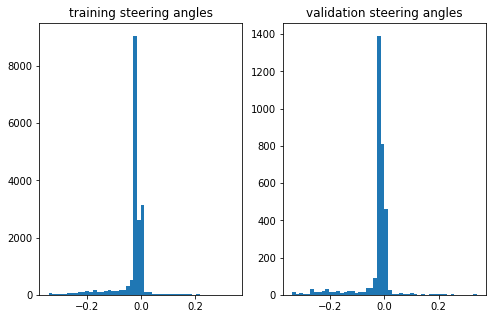

In [35]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(y_train, bins=50);
ax[0].set_title("training steering angles")
ax[1].hist(y_valid, bins=50);
ax[1].set_title("validation steering angles")
fig.set_size_inches(8,5);

# Training

Note that comparing training and validation loss is not a perfect measurement of how your RACECAR will perform in Stata basement. Solely using mean squared error on steering angles is perhaps a crude accuracy metric on this task. Also note that if you are not augmenting your validation data (and if your augmentations are not characteristic of the validation data), then the training and validation losses may be even tougher to compare.

Can you develop some more robust testing metrics for your model's performance?

In [36]:
BATCH_SIZE=20
model.fit_generator(generator=batch_generator(X_train, y_train, batch_size=BATCH_SIZE, is_training=True),
                    steps_per_epoch=4000,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, batch_size=BATCH_SIZE, is_training=False),
                    # https://stackoverflow.com/a/45944225
                    validation_steps=len(X_valid) // BATCH_SIZE,
                    callbacks=[checkpoint],
                    verbose=1);

Epoch 1/10
4000/4000 [==============================] - 166s 41ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 2/10
4000/4000 [==============================] - 160s 40ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 3/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 4/10
4000/4000 [==============================] - 163s 41ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/10
4000/4000 [==============================] - 162s 40ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 6/10
4000/4000 [==============================] - 162s 41ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/10
4000/4000 [==============================] - 162s 41ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 8/10
4000/4000 [==============================] - 163s 41ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/10
4000/4000 [==============================] - 162s 40ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 10/10
4000/4000 [==============================] 